<a href="https://colab.research.google.com/github/alexeiplatzer/unitree-go2-mjx-rl/blob/main/notebooks/Universal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Univeral Notebook for Quadruped RL Training in MJX

## Hardware Setup

In [1]:
# @title run this cell once each time on a new machine
# @markdown #### Setup configuration

# @markdown Choose your hardware option:
hardware = "Colab" # @param ["local","Colab","Kaggle"]

# @markdown Choose whether you want to build the madrona rendering setup for training
# @markdown with vision:
build_madrona_backend = False # @param {"type":"boolean"}

import time

if build_madrona_backend:
    # Install madrona MJX
    print("Intalling Madrona MJX...")
    start_time = time.perf_counter()
    print("Setting up environment... (Step 1/3)")
    !pip uninstall -y jax
    !pip install jax["cuda12_local"]==0.4.35

    !sudo apt install libx11-dev libxrandr-dev libxinerama-dev libxcursor-dev libxi-dev mesa-common-dev

    !mkdir modules
    !git clone https://github.com/shacklettbp/madrona_mjx.git modules/madrona_mjx

    !git -C modules/madrona_mjx submodule update --init --recursive

    !mkdir modules/madrona_mjx/build

    if hardware == "Kaggle":
        !sudo apt-get install -y nvidia-cuda-toolkit

    print("Building the Madrona backend ... (Step 2/3)")
    !cd modules/madrona_mjx/build && cmake -DLOAD_VULKAN=OFF .. && make -j 8

    print ("Installing Madrona MJX ... (Step 3/3)")
    !pip install -e modules/madrona_mjx

    minutes, seconds = divmod((time.perf_counter() - start_time), 60)
    print(f"Finished installing Madrona MJX in {minutes} m {seconds:.2f} s")

# Clones and installs our Quadruped RL package
!git clone https://github.com/alexeiplatzer/unitree-go2-mjx-rl.git
!pip install -e unitree-go2-mjx-rl/

Cloning into 'unitree-go2-mjx-rl'...
remote: Enumerating objects: 1131, done.
remote: Counting objects: 100% (420/420), done.
remote: Compressing objects: 100% (246/246), done.
remote: Total 1131 (delta 220), reused 296 (delta 131), pack-reused 711 (from 1)
Receiving objects: 100% (1131/1131), 22.65 MiB | 11.13 MiB/s, done.
Resolving deltas: 100% (584/584), done.
Obtaining file:///content/unitree-go2-mjx-rl
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 97.1 MB/s et

### Now restart the session and continue.
### You can skip setup next time while you are on the same machine.

## Session setup
Run once in the beggining of every session, i.e. after restarts and crashes.

In [1]:
# @title Refresh the package if any necessary changes have been pushed. Important in development
repo_path = "./unitree-go2-mjx-rl"
!git -C {repo_path} pull

Already up to date.


In [2]:
# @title Configuration for both local and for Colab instances.

# On your second reading, load the compiled rendering backend to save time!
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Check if MuJoCo installation was successful
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.'
    )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
    print('Checking that the installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".'
    )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [3]:
#@title Prepare directories
from etils.epath import Path

repo_path = Path("unitree-go2-mjx-rl")

experiments_dir = Path("experiments")
trained_policy_dir = experiments_dir / "trained_policies"
!mkdir -p {trained_policy_dir}
configs_dir = experiments_dir / "configs"
!mkdir -p {configs_dir}
rollout_configs_dir = configs_dir / "rollout_configs"
!mkdir -p {rollout_configs_dir}
animations_dir = experiments_dir / "rendered_rollouts"
!mkdir -p {animations_dir}

experiment_configs = {}

## Training

In [4]:
#@title Configure a training procedure
from quadruped_mjx_rl.configs import predefined_robot_configs
from quadruped_mjx_rl import environments
from quadruped_mjx_rl.configs.config_classes import models
from quadruped_mjx_rl.configs import TrainingConfig
from quadruped_mjx_rl.configs import save_configs

#@markdown Fill out a name for the experiment and all configuration parameters.
#@markdown If you want to add another experiment, change the parameters and run
#@markdown this cell again.
experiment_name = "my_experiment" #@param {type:"string"}
config_dict = {}
experiment_configs[experiment_name] = config_dict

#@markdown ---
#@markdown #### Choose the policy approximation method
model_architecture = "Actor-Critic" #@param ["Actor-Critic", "Teacher-Student"]
training_algorithm = "ppo" #@param ["ppo"]
vision_backend = "None" #@param ["None","Madrona"]

#@markdown ---
#@markdown #### Choose the robot
robot = "unitree_go2" #@param ["unitree_go2", "google_barkour_vb"]
config_dict["robot_config"] = predefined_robot_configs[robot]()

#@markdown ---
#@markdown #### Configure Environment
if model_architecture == "Actor-Critic" and training_algorithm == "ppo":
    env_config_class = environments.EnhancedEnvironmentConfig
else:
    raise NotImplementedError

simulation_timestep = 0.002 #@param {type:"number"}
control_timestep = 0.04 #@param {type:"number"}

config_dict["env_config"] = env_config_class(
    sim=env_config_class.SimConfig(
        sim_dt=simulation_timestep,
        ctrl_dt=control_timestep,
    ),
)

#@markdown ---
#@markdown #### Configure Model
if model_architecture == "Actor-Critic":
    #@markdown ---
    #@markdown Model hyperparameters for the "Actor-Critic" architecture:
    policy_layers = [256, 256] #@param
    value_layers = [256, 256] #@param

    model_config_class = models.ActorCriticConfig
    model_config = model_config_class(
        modules=model_config_class.ActorCriticModulesConfig(
            policy=policy_layers,
            value=value_layers,
        ),
    )
elif model_architecture == "Teacher-Student":
    #@markdown ---
    #@markdown Model hyperparameters for the "Teacher-Student" architecture:
    policy_layers = [256, 256] #@param
    value_layers = [256, 256] #@param
    teacher_encoder_layers = [256, 256] #@param
    student_encoder_layers = [256, 256] #@param
    latent_representation_size = 16 # @param {"type":"integer"}

    model_config_class = models.TeacherStudentConfig
    model_config = model_config_class(
        modules=model_config_class.TeacherStudentModulesConfig(
            policy=policy_layers,
            value=value_layers,
            encoder=teacher_encoder_layers,
            adapter=student_encoder_layers,
        ),
        latent_size=latent_representation_size,
    )
config_dict["model_config"] = model_config

#@markdown ---
#@markdown #### Configure training procedure
if vision_backend == "None":
    #@markdown ---
    #@markdown #### Training without vision:
    training_config = TrainingConfig(
        num_timesteps=1_000_000 #@param {"type":"integer"}
        ,
        num_evals=5 #@param {"type":"integer"}
        ,
        reward_scaling=1 #@param {"type":"integer"}
        ,
        episode_length=1000 #@param {"type":"integer"}
        ,
        normalize_observations=True #@param {"type":"boolean"}
        ,
        action_repeat=1 #@param {"type":"integer"}
        ,
        unroll_length=10 #@param {"type":"integer"}
        ,
        num_minibatches=8 #@param {"type":"integer"}
        ,
        num_updates_per_batch=8 #@param {"type":"integer"}
        ,
        discounting=0.97 #@param {"type":"number"}
        ,
        learning_rate=0.0005  #@param {"type":"number"}
        ,
        entropy_cost=0.005  #@param {"type":"number"}
        ,
        num_envs=512 #@param {"type":"integer"}
        ,
        batch_size=256 #@param {"type":"integer"}
    )
elif vision_backend == "Madrona":
    training_config_class = TrainingWithVisionConfig
else:
    raise NotImplementedError
config_dict["training_config"] = training_config

config_file_path = configs_dir / f"{experiment_name}.yaml"
configs_to_save = [
    config_dict[config_key]
    for config_key in config_dict.keys() if config_key.endswith("_config")
]
save_configs(config_file_path, *configs_to_save)
print(f"Experiment configs saved to {config_file_path}")

Experiment configs saved to experiments/configs/my_experiment.yaml


In [5]:
#@title List all configured experiments
!ls {configs_dir}

my_experiment.yaml  rollout_configs


Starting training for: my_experiment


/content/unitree-go2-mjx-rl/src/quadruped_mjx_rl/models/agents/ppo/raw_ppo/training.py:449: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  env_steps=jnp.array(0, dtype=jnp.int64),


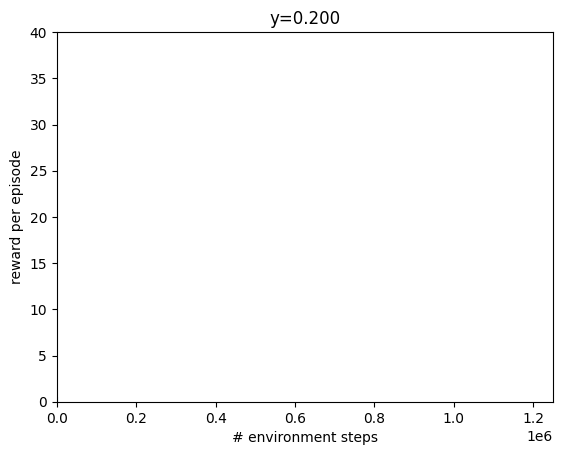

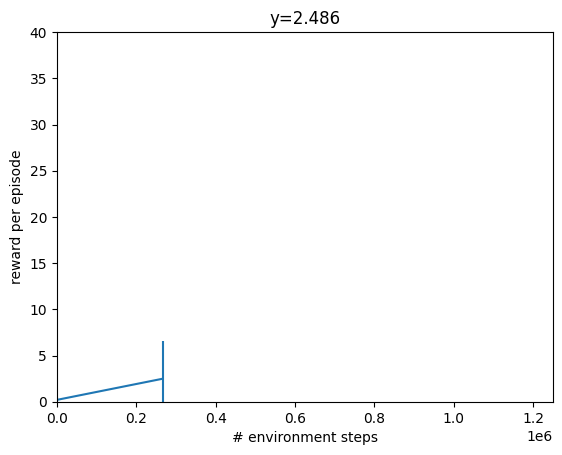

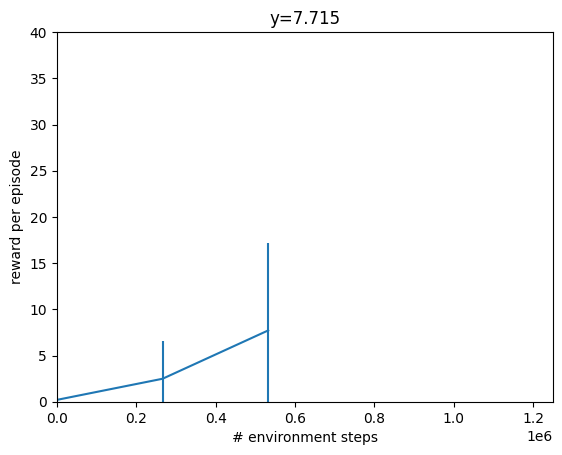

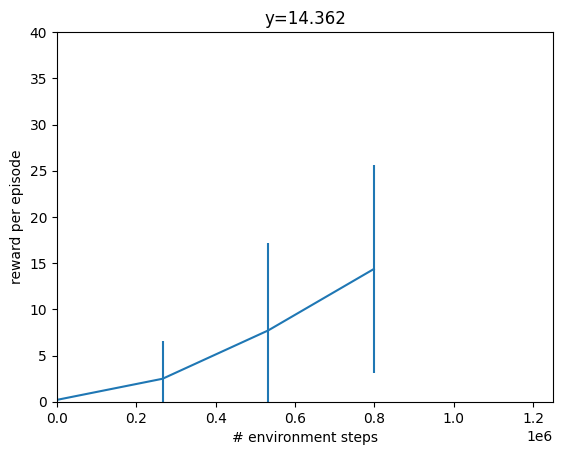

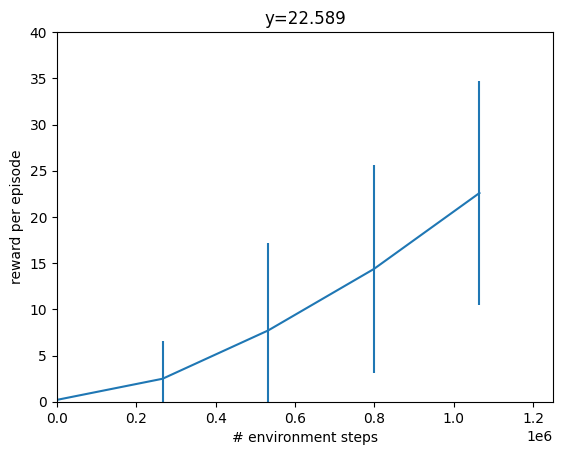

time to jit: 0:01:49.050607
time to train: 0:03:14.330778
Trained policy saved to experiments/trained_policies/my_experiment


In [6]:
#@title Run training for all experiments
from quadruped_mjx_rl.configs import prepare_configs, ConfigKey
from quadruped_mjx_rl.training import train
from quadruped_mjx_rl import environments
from quadruped_mjx_rl.models.agents.ppo.raw_ppo.training import train as train_ppo_ac
from quadruped_mjx_rl.models.agents.ppo.guided_ppo.training import train as train_ppo_ts

#@markdown Choose with which configs to train
training_runs = None # @param {"type":"raw","placeholder":"[\"experiment_name1\", \"experiment_name2\", ... ]"}
#@markdown or
run_them_all = True # @param {"type":"boolean"}
if run_them_all:
    training_runs = [
        config_file.stem
        for config_file in configs_dir.iterdir() if config_file.name.endswith(".yaml")
    ]


for experiment_name in training_runs:
    config_path = configs_dir / f"{experiment_name}.yaml"
    configs = prepare_configs(config_path)
    environment_config = configs[ConfigKey.ENVIRONMENT]
    robot_config = configs[ConfigKey.ROBOT]
    model_config = configs[ConfigKey.MODEL]
    training_config = configs[ConfigKey.TRAINING]
    vision_config = configs.get(ConfigKey.VISION)

    init_scene_path = repo_path / "resources" / robot_config.robot_name / "scene_mjx.xml"

    train_function = train_ppo_ac
    match type(environment_config):
        case environments.TeacherStudentEnvironmentConfig:
            env_class = environments.QuadrupedJoystickTeacherStudentEnv
            train_function = train_ppo_ts
        case environments.EnhancedEnvironmentConfig:
            env_class = environments.QuadrupedJoystickEnhancedEnv
        case environments.EnvironmentConfig:
            env_class = environments.QuadrupedJoystickBaseEnv
        case _:
            raise NotImplementedError

    def env_factory():
        return env_class(
            environment_config=environment_config,
            robot_config=robot_config,
            init_scene_path=init_scene_path,
        )

    del training_config.training_class

    trained_policy_save_path = trained_policy_dir / f"{experiment_name}"

    print(f"Starting training for: {experiment_name}")
    train(
        env_factory=env_factory,
        model_config=model_config,
        training_config=training_config,
        train_fn=train_function,
        model_save_path=trained_policy_save_path,
        checkpoints_save_path=None, #TODO: enable
        vision=False, #TODO: enable
    )
    print(f"Trained policy saved to {trained_policy_save_path}")

## Results
This section can be run independently from the training section, including after restarts and crashes. As long as all the created files remain in the session's disk memory.

In [7]:
#@title List all configured experiments
!ls {configs_dir}

my_experiment.yaml  rollout_configs


In [8]:
# @title Configure a rollout for rendering
from quadruped_mjx_rl.configs import RenderConfig, save_configs

experiment_name = "my_experiment" #@param {type:"string"}
rollout_name = "my_rollout" #@param {type:"string"}

n_steps = 500 #@param {"type":"integer"}
render_every = 2 #@param {"type":"integer"}
random_seed = 0 #@param {"type":"integer"}

#@markdown ---
#@markdown Joystick command for the robot to follow (in SI)
x_vel = 1.0 #@param {"type":"number"}
y_vel = 0.0 #@param {"type":"number"}
ang_vel = 0.0 #@param {"type":"number"}

render_config = RenderConfig(
    n_steps=n_steps,
    episode_length=n_steps * 2,
    render_every=render_every,
    seed=random_seed,
    command={
        "x_vel": x_vel,
        "y_vel": y_vel,
        "ang_vel": ang_vel,
    },
)

config_file_path = rollout_configs_dir / f"{experiment_name}_rendering_{rollout_name}.yaml"
save_configs(config_file_path, render_config)
print(f"Rollout configs saved to {config_file_path}")

Rollout configs saved to experiments/configs/rollout_configs/my_experiment_rendering_my_rollout.yaml


In [9]:
#@title Render all configured policy rollouts
from quadruped_mjx_rl.rendering import render
from quadruped_mjx_rl import environments
from quadruped_mjx_rl.configs import EnvironmentConfig, prepare_configs
from quadruped_mjx_rl.configs import ConfigKey

#@markdown All rollouts present will be rendered
delete_rollouts_after_rendering = True #@param {"type":"boolean"}
save_rollout_gifs = True #@param {"type":"boolean"}

for experiment_config_file in configs_dir.iterdir():
    if not experiment_config_file.name.endswith(".yaml"):
        continue
    experiment_name = experiment_config_file.stem
    configs = prepare_configs(experiment_config_file)
    environment_config = configs[ConfigKey.ENVIRONMENT]
    robot_config = configs[ConfigKey.ROBOT]
    model_config = configs[ConfigKey.MODEL]
    vision_config = configs.get(ConfigKey.VISION)

    init_scene_path = repo_path / "resources" / robot_config.robot_name / "scene_mjx.xml"

    match type(environment_config):
        case environments.TeacherStudentEnvironmentConfig:
            env_class = environments.QuadrupedJoystickTeacherStudentEnv
        case environments.EnhancedEnvironmentConfig:
            env_class = environments.QuadrupedJoystickEnhancedEnv
        case environments.EnvironmentConfig:
            env_class = environments.QuadrupedJoystickBaseEnv
        case _:
            raise NotImplementedError

    def env_factory():
        return env_class(
            environment_config=environment_config,
            robot_config=robot_config,
            init_scene_path=init_scene_path,
        )

    trained_policy = trained_policy_dir / f"{experiment_name}"

    rollout_configs_list = []
    for rollout_config_file in rollout_configs_dir.iterdir():
        if (
            not rollout_config_file.name.endswith(".yaml")
            or "_rendering_" not in rollout_config_file.name
            or experiment_name != rollout_config_file.name.split("_rendering_")[0]
        ):
            print(not rollout_config_file.name.endswith(".yaml") )
            print("_render_" not in rollout_config_file.name)
            print(experiment_name != rollout_config_file.name.split("_render_")[0])
            print(experiment_name)
            print(rollout_config_file.name.split("_render_")[0])
            print(rollout_config_file.name)
            continue
        rollout_configs_list.append(rollout_config_file)

        render_config = prepare_configs(rollout_config_file)

        if save_rollout_gifs:
            animation_save_path = animations_dir / f"{rollout_config_file.stem}.gif"
        else:
            animation_save_path = None

        render(
            env_factory=env_factory,
            model_config=model_config,
            trained_model_path=trained_policy,
            render_config=render_config,
            animation_save_path=animation_save_path,
            vision=False,
        )

    if delete_rollouts_after_rendering:
        for rollout_config_file in rollout_configs_list:
            rollout_config_file.unlink()

In [16]:
#@title Saving results
from google.colab import files, drive
from etils.epath import Path

#@markdown (This can be run in a separate session)

#@markdown Choose what you want to save
policies = True #@param {"type":"boolean"}
rollout_gifs = True #@param {"type":"boolean"}
config_files = True #@param {"type":"boolean"}
#@markdown Only the configs for the training are saved

#@markdown Choose whether you want to download your results
download_results = False # @param {"type":"boolean"}

#@markdown Choose whether you want to save results to your Google drive
save_to_drive = True # @param {"type":"boolean"}
drive_save_folder = "quadruped_mjx_rl_Results" # @param {type:"string"}
if save_to_drive:
    drive.mount('/content/drive')

for do_save, directory in zip(
    [policies, rollout_gifs, config_files], [trained_policy_dir, animations_dir, configs_dir],
):
    if not do_save:
        continue
    for file_path in directory.iterdir():
        if file_path.is_dir():
            continue
        if download_results:
            files.download(file_path)
        if save_to_drive:
            drive_dir = Path(f"/content/drive/MyDrive/{drive_save_folder}/{directory.name}")
            drive_dir.mkdir(parents=True, exist_ok=True)
            file_path.copy(
                dst=drive_dir / file_path.name, overwrite=True
            )

if save_to_drive:
    drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
